# Project 2: Advanced Lane Finding

## Camera calibration
In this section, the camera calibration will be performed

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 1. Find Chesboard corners for each image and create objjpoints and imgpoints lists

In [2]:
#Define size of the chessboard
nx = 9
ny = 6

#Initialize lists for image points and object points
objpoints = []
imgpoints = []

#If you want the code to plot the chess board corners, set plot as True
plot = False
if plot:
    n_images = len(os.listdir('camera_cal'))
    fix, axs = plt.subplots(n_images,2, figsize=(10,5*n_images))
    
    
#Loop around all calibration images    
for i, image in enumerate(os.listdir('camera_cal')):
    
    #Create images object points
    obpj = np.zeros((ny*nx,3), np.float32)
    obpj[:,:2] = np.mgrid[:nx,:ny].T.reshape(-1,2)
    
    #Read image
    img = cv2.imread('camera_cal/'+image)
    
    #Show original image
    if plot:
        ax = axs[i,0]
        ax.imshow(img)
        
    #Convert to grayscale    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Identify chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    #If chessboard corners were found
    if ret:
        if plot:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            ax = axs[i,1]
            ax.imshow(img)
        
        #Append image points and object points
        imgpoints.append(corners)
        objpoints.append(obpj) 
    else:
        print("Not found corners for ",image)

Not found corners for  calibration1.jpg
Not found corners for  calibration4.jpg
Not found corners for  calibration5.jpg


### 2. Calibrate camera
Calibrate camera using the imgpoints and objpoints from all the calibration images

In [3]:
#Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)  

### 3. Test on images

In [4]:
#Functions that correct distortion of image
def corners_unwarp(img, nx, ny, mtx, dist):
    
    # Undisort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        #Draw corners
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        offset = 100 # offset
        #Image shape
        img_size = (gray.shape[1], gray.shape[0])

        #Defne sources points fo transformation
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # Define destination points for transformation
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
        # Obtain the perpective transformed image
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

        # Return the resulting image and matrix
        return warped, M
    
    else:
        return [], []

Not found corners for  calibration1.jpg
Not found corners for  calibration4.jpg
Not found corners for  calibration2.jpg
Not found corners for  calibration5.jpg


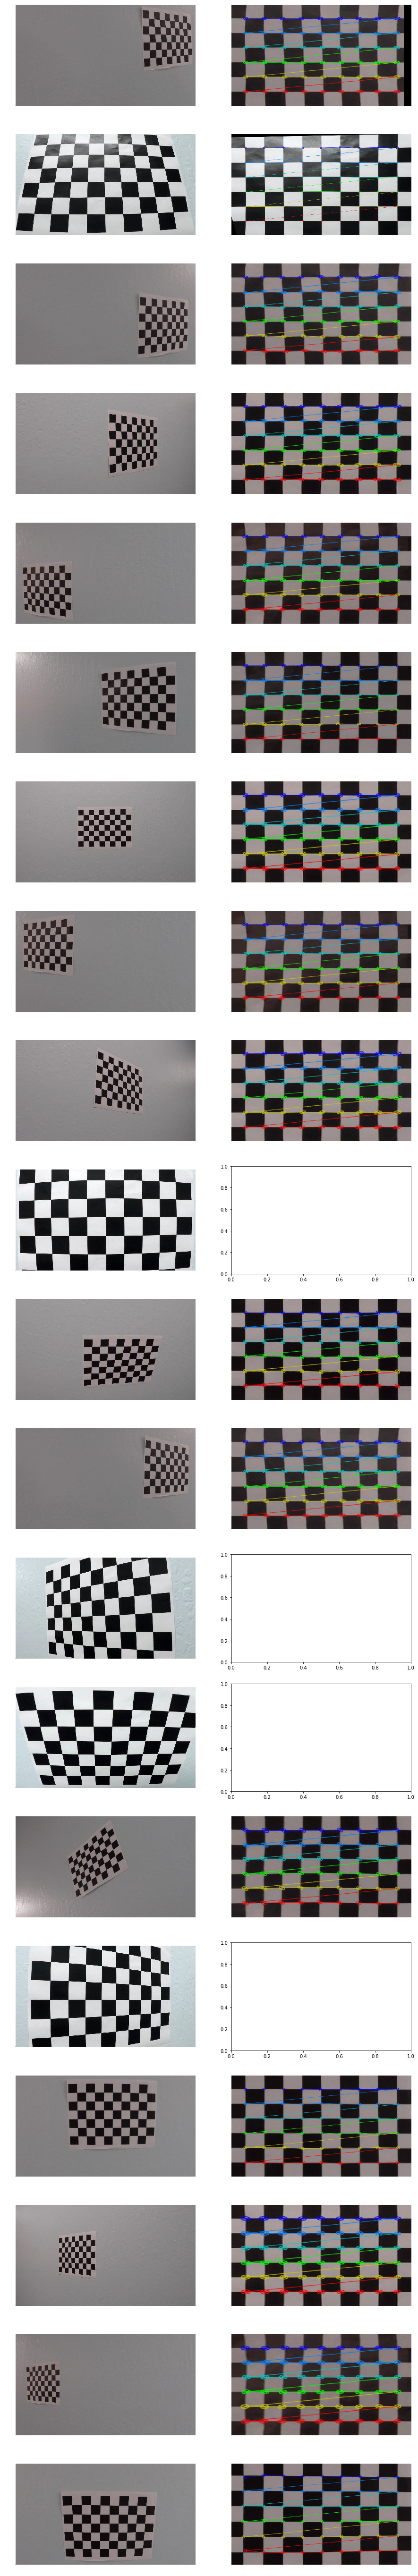

In [6]:
#Craete subplot to show images
n_images = len(os.listdir('camera_cal'))
fig, axs = plt.subplots(n_images,2, figsize=(15,5*n_images))

#Loop around all images
for i, image in enumerate(os.listdir('camera_cal')):
    
    #Read image
    img = cv2.imread('camera_cal/'+image)
    
    #Show original image
    ax = axs[i,0]
    ax.imshow(img)
    ax.axis('off')
    
    #Saving each image independently
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig('camera_cal_output_images/original_'+image, bbox_inches=extent)  
    
    #Process image with corners_unwarp function
    img, M = corners_unwarp(img, nx, ny, mtx, dist)
    
    #If chessboard were found
    if len(M) > 0:
        ax = axs[i,1]
        ax.imshow(img)
        ax.axis('off')
    else:
        print("Not found corners for ",image)
        
    #Saving each image independently
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig('camera_cal_output_images/transformed_'+image, bbox_inches=extent)    

## Pipeline of road images

In [11]:
def transform_image(img,s_thresh_min = 170,s_thresh_max = 255,thresh_min = 20,thresh_max = 100):
    #1. Convert to HSL and take the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    #2. S channel threshold 
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    #3. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #4. Apply sobel in x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #5. Sobel threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    #6. Output
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary, color_binary

In [12]:
def measure_curvature_real(leftx, lefty, rightx, righty):
        
    # Conversions rates
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Convert the points used for polyfit
    lefty = lefty*ym_per_pix
    righty = righty*ym_per_pix
    leftx = leftx*xm_per_pix
    rightx = rightx*xm_per_pix
    
    #Polyfit
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)
    
    # Define the maximum point of y
    y_eval = np.max(lefty)
    
    #Calculate curvature for left and right lines
    left_curverad = (1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2)/(np.abs(2*left_fit_cr[0]))  
    right_curverad = (1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2)/(np.abs(2*right_fit_cr[0]))  
    
    
    return left_curverad, right_curverad

In [13]:
def get_car_offset(left_fit, right_fit, y_max, mid_point):
    left_x = left_fit[0]*(y_max**2)+left_fit[1]*y_max+left_fit[2]
    right_x = right_fit[0]*(y_max**2)+right_fit[1]*y_max+right_fit[2]
    
    right_dist = right_x-mid_point
    left_dist = mid_point-left_x
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    offset = np.abs(right_dist-left_dist)*xm_per_pix
    
    if right_dist > left_dist:
        return offset, "left"
    else:
        return offset, "right"

In [18]:
def get_polys(img, histogram, polys=([],[]), debug=False):
    
    #Get polynomials of last frame
    left_fit = polys[0]
    right_fit = polys[1]
    
    #Create output image
    out_img = np.dstack((img, img, img))*255
    
    nwindows = 9
    margin = 50
    minpix = 50
    
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    
    left_lane_inds = []
    right_lane_inds = []
    
    #If there are previous frames
    if len(right_fit) > 0:
        #If debug enable, create subplot
        if debug:
            fig, axs = plt.subplots(1, 1, figsize=(10,5))
    
        #Get pixels based on previous polynomial +/- the margin
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        #Fit new polynomials
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        #Measure Curvature
        left_curv, right_curv = measure_curvature_real(leftx, lefty, rightx, righty)
        
        #Get the position of x for y=0 for previous polynomial and compare with the current one
        uprightx = polys[0][2] 
        xchange = np.abs(left_fit[2]-polys[0][2])
        
        #If the change is greater than the margin, recalculate the polynomial
        if np.abs(left_fit[2]-polys[0][2]) > margin:
            #Add new points based on previous polynomial to decrease the change
            old_pointsx = polys[0][0]*(lefty**2) + polys[0][1]*lefty +  polys[0][2]
            new_lefty = np.concatenate((lefty,lefty), axis=0)
            new_leftx = np.concatenate((leftx,old_pointsx), axis=0)
            
            #Recalculate polynomial and measure curvature again
            left_fit = np.polyfit(new_lefty, new_leftx, 2)
            n_left_curv, right_curv = measure_curvature_real(new_leftx, new_lefty, rightx, righty)            
            left_curv = n_left_curv
        
        #Repeat the process for the right line
        xchange = np.abs(right_fit[2]-polys[1][2])
        if np.abs(right_fit[2]-polys[1][2]) > margin:  
            #Add new points based on previous polynomial to decrease the change
            old_pointsx = polys[1][0]*(righty**2) + polys[1][1]*righty +  polys[1][2]
            new_righty = np.concatenate((righty,righty), axis=0)
            new_rightx = np.concatenate((rightx,old_pointsx), axis=0)
            
            #Recalculate polynomial and measure curvature again
            right_fit = np.polyfit(new_righty, new_rightx, 2)
            left_curv, n_right_curv = measure_curvature_real(leftx, lefty, new_rightx, new_righty)
            right_curv = n_right_curv
        
        #Show image
        if debug:
            #Add polynomial lines to image
            ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]
            ax = axs[0]
            ax.imshow(out_img)
            ax.plot(left_fitx, ploty, color='yellow')
            ax.plot(right_fitx, ploty, color='red')
            ax.set_xlim(0, img.shape[1])
    
    #If this the first frame
    else: 
        
        #If debug enable, create subplot
        if debug:
            fig, axs = plt.subplots(len(range(int(nwindows/2),nwindows)), 1, figsize=(10,5*len(range(int(nwindows/2),nwindows))))
        
        #Define midpoint
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        leftx_current = leftx_base
        rightx_current = rightx_base
    
        cont = 0
        #Loop around windows. The first window will containt the information of the botton half of the image
        for window in range(int(nwindows/2),nwindows):
            cont += 1
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            if len(right_fit) == 0: #The first window will check the bottom half section of the image
                left_lane_inds = ((nonzeroy >= img.shape[0]//2) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                right_lane_inds = ((nonzeroy >= img.shape[0]//2) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            else: #After that, the window height will be considered
                c_nonzeroy = nonzeroy[nonzeroy >= win_y_low]
                c_nonzerox = nonzerox[nonzeroy >= win_y_low]


                left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)) & (nonzeroy >= win_y_low))
                right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)) & (nonzeroy >= win_y_low))  


            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            #Fit polynomials
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            currenty = img.shape[0] - (window+0.5)*window_height
            leftx_current = np.int(left_fit[0]*(currenty**2) + left_fit[1]*currenty + left_fit[2])
            rightx_current = np.int(right_fit[0]*(currenty**2) + right_fit[1]*currenty + right_fit[2])


            #Measure Curvature
            left_curv, right_curv = measure_curvature_real(leftx, lefty, rightx, righty)


            ####Show image with lines###
            if debug:
                ploty = np.linspace(win_y_low, img.shape[0]-1, img.shape[0]-win_y_low)
                left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
                right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

                out_img[lefty, leftx] = [255, 0, 0]
                out_img[righty, rightx] = [0, 0, 255]
                ax = axs[cont-1]
                ax.imshow(out_img)
                ax.plot(left_fitx, ploty, color='yellow')
                ax.plot(right_fitx, ploty, color='red')
                ax.set_xlim(0, img.shape[1])
        
    return out_img, left_fit, right_fit, [lefty, leftx,righty, rightx], (left_curv, right_curv)
    

### Image pipeline

In [21]:
def image_pipeline(original_img, polys=([],[]), show=False):
    
    if show:
        fix, axs = plt.subplots(4,2, figsize=(15,4*4))

        #Show original image
        ax = axs[0,0]
        ax.imshow(original_img) 
        ax.axis('off')

    #1. Correct for distortion
    img = cv2.undistort(original_img, mtx, dist, None, mtx)
    
    if show:
        ax = axs[0,1]
        ax.imshow(img) 
        ax.axis('off')

    #2. Threshold binary image
    img, img2 = transform_image(img,s_thresh_min = 170,s_thresh_max = 230,thresh_min = 60,thresh_max = 95)
    
    if show:
        ax = axs[1,0]
        ax.imshow(img2) 
        ax.axis('off')
        
        ax = axs[1,1]
        ax.imshow(img)

    #3. Perspective transformation
    offset = 300
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    
    src = np.float32([[(1280/2)*.9, (720/2)*1.3], [(1280/2)*1.1, (720/2)*1.3], [1100,720], [200,720]])
    
    if show:
        ax.scatter(src[:,0], src[:,1], color='r')
        ax.scatter(dst[:,0], dst[:,1], color='b')
    
    M = cv2.getPerspectiveTransform(src, dst)
    img = cv2.warpPerspective(img, M, img_size)
    
    if show:
        ax = axs[2,0]
        ax.imshow(img) 
        ax.axis('off')
    
    realimg = cv2.warpPerspective(original_img, M, img_size)
    
    #4. Calculate histogram of botton half
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    if show:
        ax = axs[2,1]
        ax.plot(histogram)
    
    #5. Get polynomials
    out_img, left_fit, right_fit, colored, curvs = get_polys(img, histogram, polys=polys)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if show:
        ax = axs[3,0]
        ax.imshow(realimg)
        ax.plot(left_fitx, ploty, color='yellow')
        ax.plot(right_fitx, ploty, color='yellow')
    
    #6. Create mask
    mask = np.zeros_like(realimg) 
    if len(realimg.shape) > 2:
        channel_count = realimg.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (0,) * channel_count
    else:
        ignore_mask_color = 0
    
    vertices = np.array([[(img_size[0], 0), (0, 0), (0,img_size[1]), (img_size[0],img_size[1])]], dtype='int32')
    out_img = cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    X = np.concatenate((right_fitx,np.flip(left_fitx,0)), axis=0)
    X = X.reshape((len(X),1))
    Y = np.concatenate((ploty, np.flip(ploty,0)), axis=0)
    Y = Y.reshape((len(X),1))
    poly = np.hstack((X,Y))
    out_img = cv2.fillPoly(out_img, np.int32([poly]),color=(0,255,0))
    
    out_img[colored[0], colored[1]] = [255, 0, 0]
    out_img[colored[2], colored[3]] = [0, 0, 255]
    
    #7. Transform back to original image
    M = cv2.getPerspectiveTransform(dst, src)
    out_img = cv2.warpPerspective(out_img, M, img_size)

    if show:
        ax = axs[3,1]
        ax.imshow(original_img)
        ax.imshow(out_img)

        plt.show() 
    
    α=0.8
    β=1.
    γ=0.
    out_img = cv2.addWeighted(original_img, α, out_img, β, γ)
    
    
    #8. Write curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    out_img = cv2.putText(out_img,"Radius of Curvature (m) = "+str(np.round(np.mean(curvs))),(0,30), font, 1, (200,255,155), 2, cv2.LINE_AA)
    
    #9. Calculate and write offset
    offset, side = get_car_offset(left_fit, right_fit, img_size[1], img_size[0]/2)
    out_img = cv2.putText(out_img,"Vehicule is "+str(np.round(offset,3))+' '+side+' of the center',(0,60), font, 1, (200,255,155), 2, cv2.LINE_AA)
    
    return out_img, (left_fit, right_fit), curvs   

### Load all test images and plot

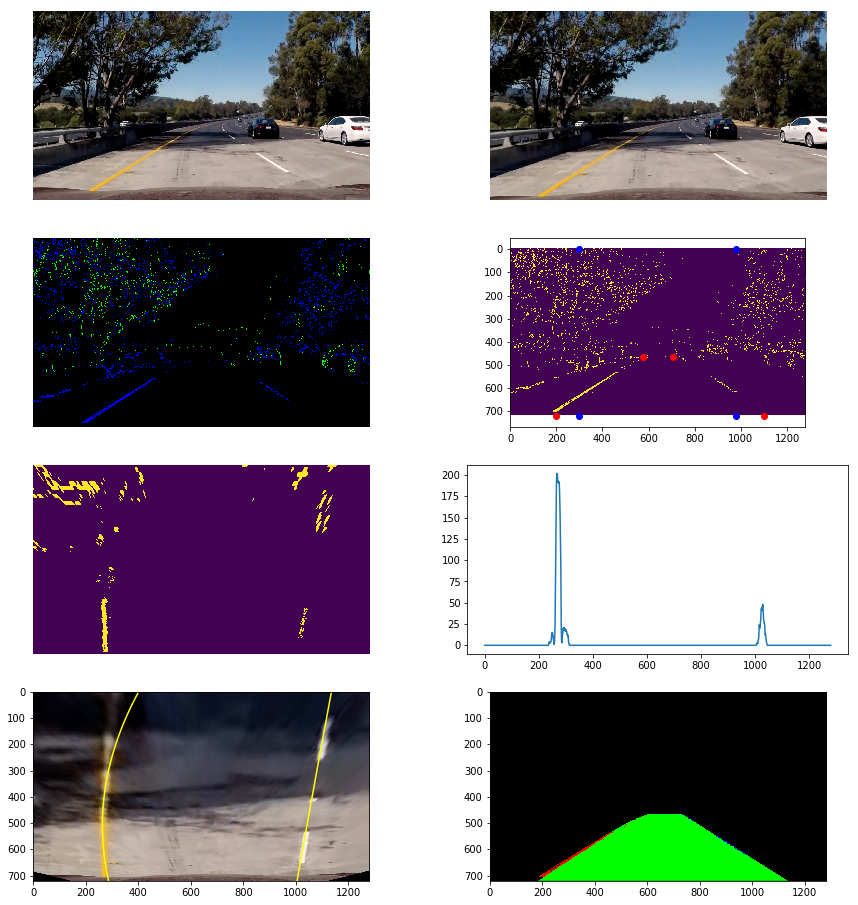

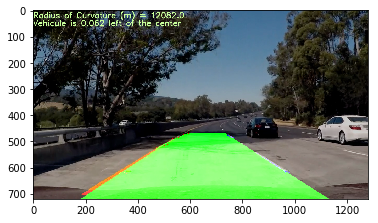

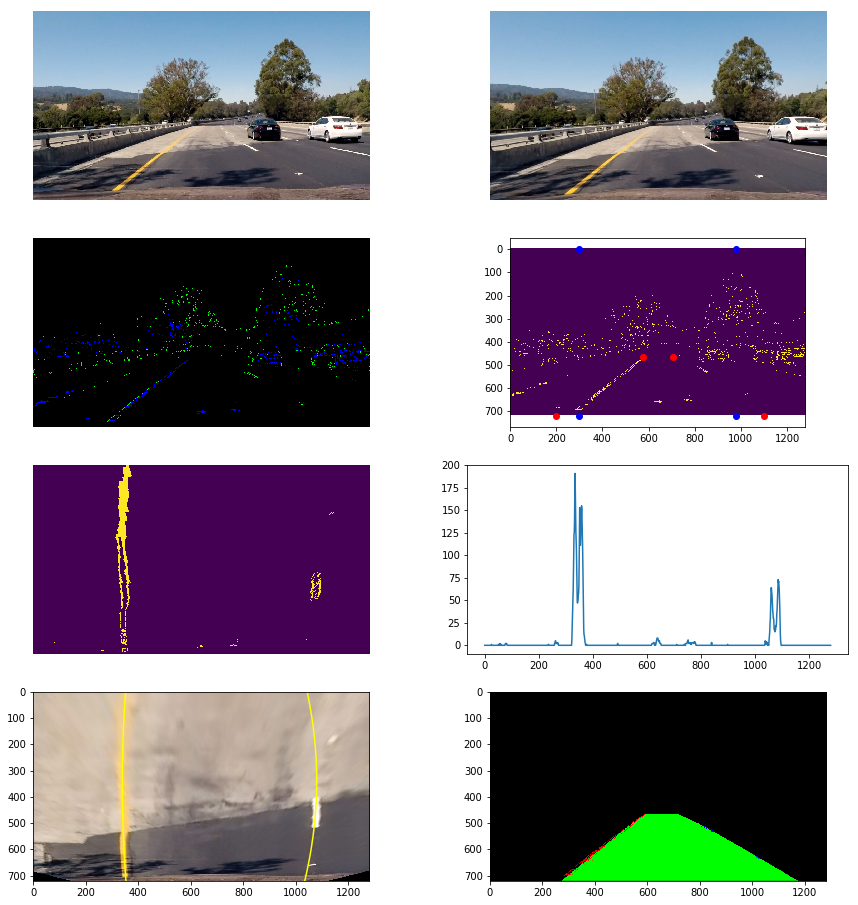

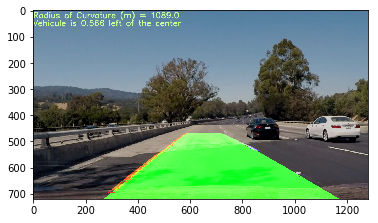

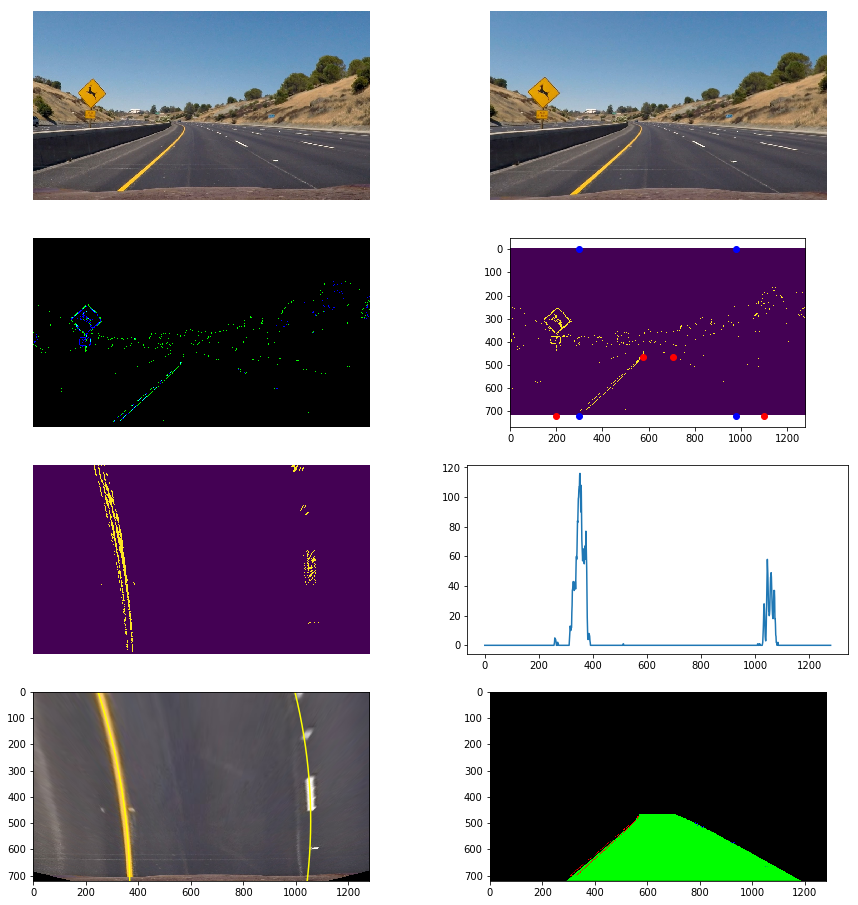

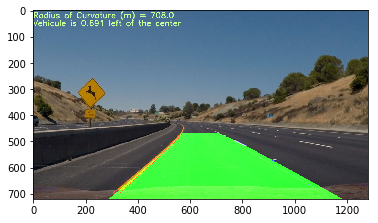

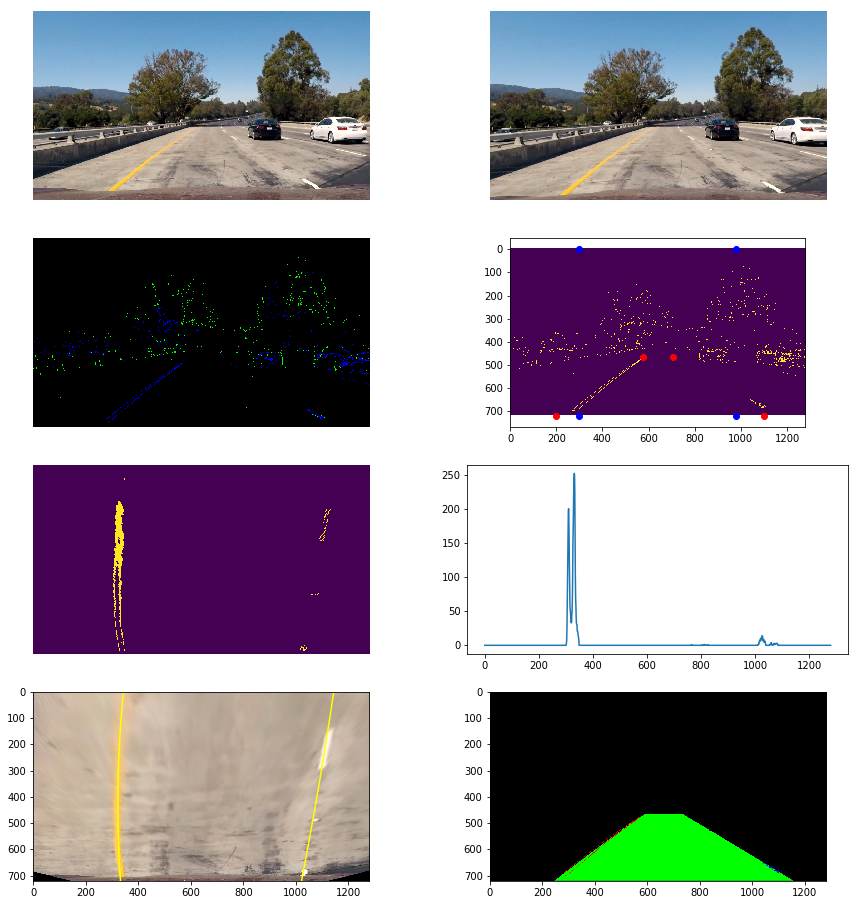

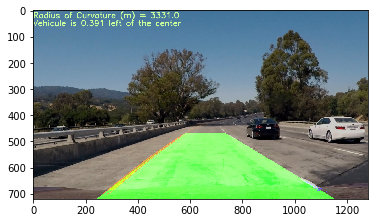

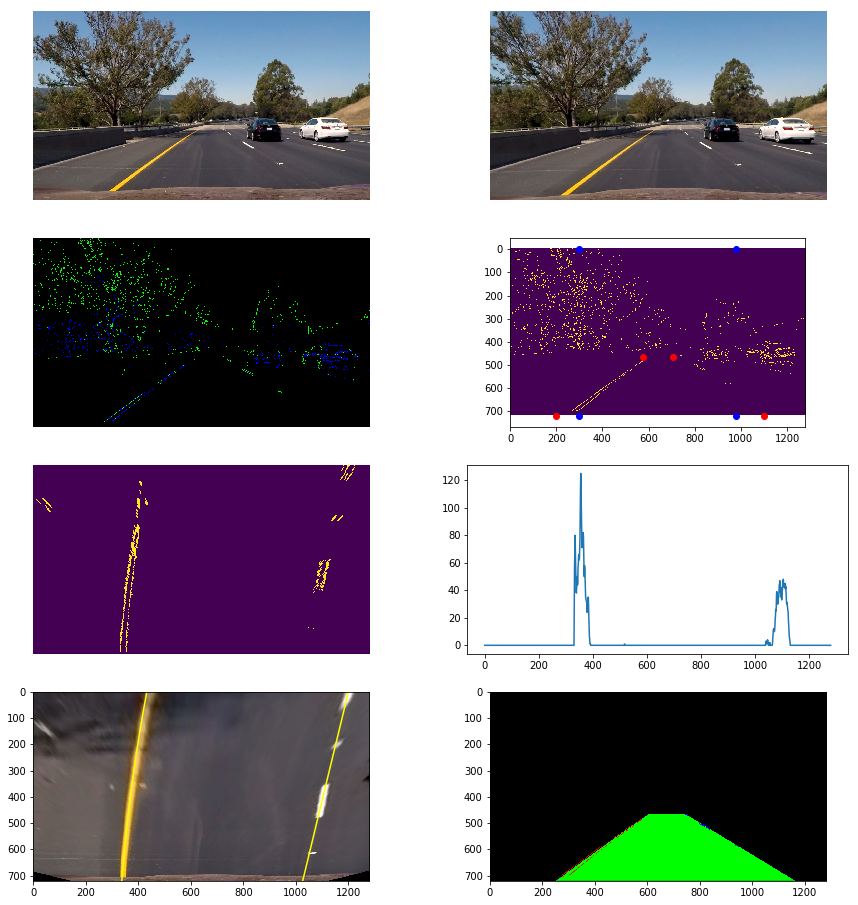

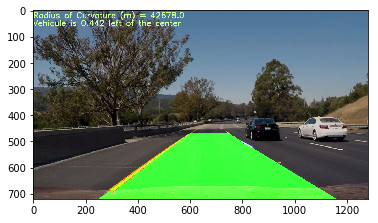

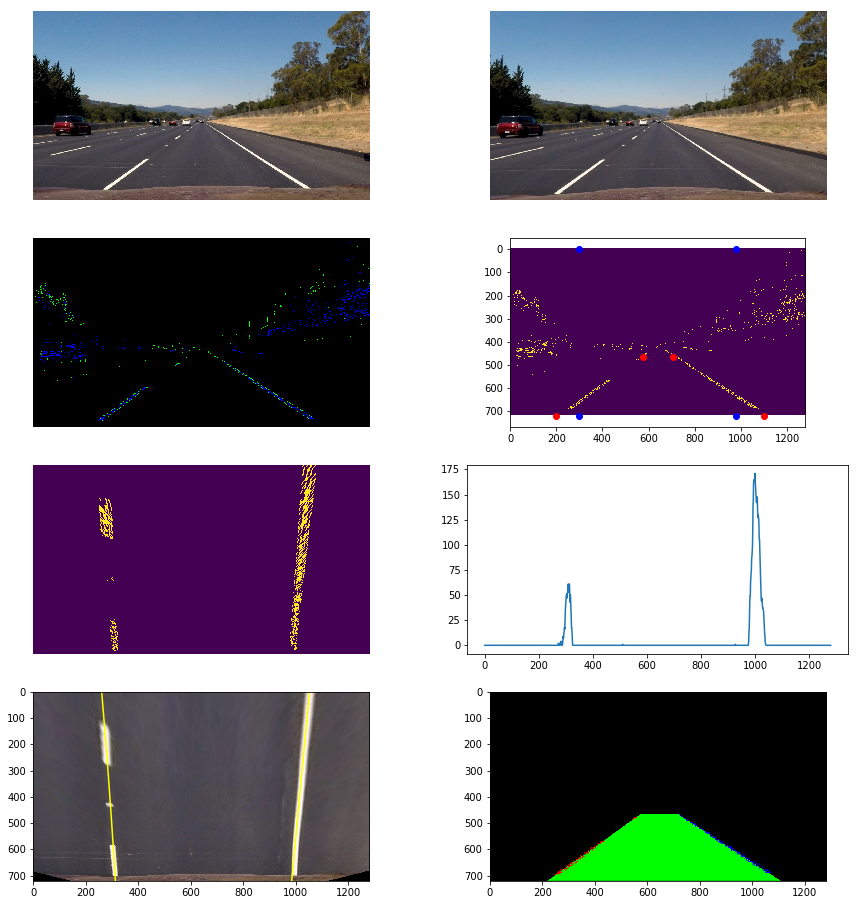

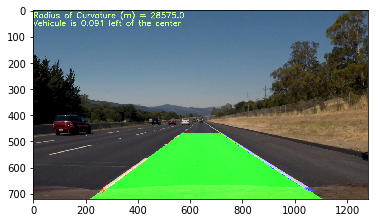

In [ ]:
#Craete subplot to show images
n_images = len(os.listdir('test_images'))
7#Loop around all test iamges
for i in range(n_images):
    
    show_image = i #Defines if the user wants to see all images or just one in specific
    
    if i==show_image:
        image = os.listdir('test_images')[i]
    else:
        continue

    #Read image
    original_img = mpimg.imread('test_images/'+image)
    
    #Call image pipeline
    img, _, _ = image_pipeline(original_img, show=True)
    
    #Show image
    plt.imshow(img)
    plt.show() 
        


### Load video

In [23]:
yellow_output = 'output_videos/project_video_11.mp4'

In [24]:
#Video class to save information related to polynomials
class ProcessVideo:
    def __init__(self):
        #Initialize polynomials properties
        self.polyright = []
        self.polyleft = []
        
    def __call__(self, image):
        #Call image pipeline
        image, poly, curvs = image_pipeline(image,polys=(self.polyleft, self.polyright))
        
        #Update polynomials values
        self.polyleft = poly[0]
        self.polyright = poly[1]
        
        return image

In [28]:
#Initialize object of type ProcessVideo()
processingVideo = ProcessVideo()

In [26]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('project_video.mp4').subclip(35,36)
#clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(processingVideo)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_11.mp4
[MoviePy] Writing video output_videos/project_video_11.mp4


 96%|█████████▌| 25/26 [00:05<00:00,  4.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_11.mp4 

CPU times: user 4 s, sys: 463 ms, total: 4.46 s
Wall time: 6.78 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))